In [3]:
import random
import json
import numpy as np
from src.gameSimulation.GameUr import GameUr, Player, Dice, GameSettings
import src.gameSimulation.Strategies as Strats
import src.gameSimulation.Multirun as Multirun
import gameBoardDisplay as gbd

from scipy import stats


# %config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mplTicker
import matplotlib.style as mplstyle
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

mplstyle.use('fast')
mplstyle.use('default')
# mpl.rcParams['figure.figsize'] = [20, 10]

colors = ["lightgreen", "yellow", "red"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)






In [62]:
rs = Strats.RandomStrategy()
mfs = Strats.MoveFirstStrategy()
mls = Strats.MoveLastStrategy()
# strategies = [Strategies.RandomStrategy,
#               Strategies.MoveFirstStrategy,
#               Strategies.MoveLastStrategy]
strategies = [Strats.MoveFirstStrategy]
p0 = Player(0,7,mls)
p1 = Player(1, 7, mfs)
p2 = Player(2, 7, rs)
# p3 = Player(3, 4, rs)
md2 = Dice.MultiD2Dice(4)
d4 = Dice.D4()
# gs = GameSettings([p0,p1],d,4,8,2,[8],[4,8,13],exactFinish=False)
gs0 = GameSettings([p0, p1], md2, 4, 8, 2, [8], [4, 8, 13])
gs1 = GameSettings([p1, p2], md2, 4, 8, 2, [8], [4, 8, 13])
# gs = [gs0,gs1]

    
# gs = [GameSettings([Player(0, 7, s0()), Player(1, 7, s1())],
#                    Dice.MultiD2Dice(4), 14, 0, 0, [], []) for s1 in strategies for s0 in strategies]


# gs = [GameSettings([Player(0, 7, Strategies.MoveFirstStrategy()), Player(1, 7, Strategies.MoveFirstStrategy())], Dice.MultiD2Dice(4), 14, 0, 0, [], []),
#       GameSettings([Player(0, 7, Strategies.MoveFirstStrategy()), Player(1, 7, Strategies.MoveFirstStrategy())], Dice.MultiD2Dice(4), 4, 8, 2, [], []),
#       GameSettings([Player(0, 7, Strategies.MoveFirstStrategy()), Player(1, 7, Strategies.MoveFirstStrategy())], Dice.MultiD2Dice(4), 4, 8, 2, [8], [4,8,13]),
# ]

# gs = [GameSettings([Player(0, 7, Strategies.MoveFirstStrategy()), Player(1, 7, Strategies.MoveFirstStrategy())], Dice.MultiD2Dice(4), 4, 8, 2, [8], [4,8,13]),
#       GameSettings([Player(0, 7, Strategies.MoveFirstStrategy()), Player(1, 7, Strategies.MoveFirstStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
#       GameSettings([Player(0, 7, Strategies.MoveFirstStrategy()), Player(1, 7, Strategies.MoveFirstStrategy())], Dice.MultiD2DiceNo0(3), 4, 8, 2, [8], [4, 8, 13]),
#       GameSettings([Player(0, 7, Strategies.MoveFirstStrategy()), Player(1, 7, Strategies.MoveFirstStrategy())], Dice.D4(), 4, 8, 2, [8], [4, 8, 13]),
# ]


gs = [
      # GameSettings([Player(0, 7, Strats.MoveFirstStrategy()), Player(1, 7, Strats.MoveFirstStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
      # GameSettings([Player(0, 7, Strats.ScoreStrategy()), Player(1, 7, Strats.ScoreStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
      GameSettings([Player(0, 7, Strats.ScoreDoubleRollStrategy()), Player(1, 7, Strats.ScoreDoubleRollStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
      GameSettings([Player(0, 7, Strats.ScoreStrategy()), Player(1, 7, Strats.MoveFirstStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
      GameSettings([Player(0, 7, Strats.ScoreStrategy()), Player( 1, 7, Strats.ScoreDoubleRollStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
      GameSettings([Player(0, 7, Strats.ScoreDoubleRollStrategy()), Player( 1, 7, Strats.MoveFirstStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
      GameSettings([Player(0, 7, Strats.MoveFirstStrategy()), Player( 1, 7, Strats.ScoreDoubleRollStrategy())], Dice.MultiD2Dice(3), 4, 8, 2, [8], [4, 8, 13]),
]

xlabels=[
      # "MFs vs MFs",
      # "Ss vs Ss",
      "SDRs vs SDRs",
      "Ss vs MFs",
      "Ss vs SDRs",
      "SDRs vs MFs",
      "MFs vs SDRs",
      ]

In [63]:
g = GameUr(gs[0])
g.getStonesHistory()
g.run(500)
# with open('history.json',"w") as f:
#     json.dump(g.getStonesHistory(),f)

In [64]:
h=[Multirun.multirun(10000,gs_) for gs_ in gs]

6
1667
10002
start pool
finish pool
6
1667
10002
start pool
finish pool
6
1667
10002
start pool
finish pool
6
1667
10002
start pool
finish pool
6
1667
10002
start pool
finish pool


In [72]:
gl = [[x["gameLength"] for x in h_] for h_ in h]
gl_stacked = [[(i,gl_.count(i)) for i in range(np.min(gl_),np.max(gl_)+1)] for gl_ in gl]
[[(i,gl_.count(i)) for i in range(np.min(gl_),np.max(gl_)+1)].count(0) for gl_ in gl]

# gl_stacked
# np.average(gl)
# np.min(gl)
# np.max(gl)


[0, 0, 0, 0, 0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


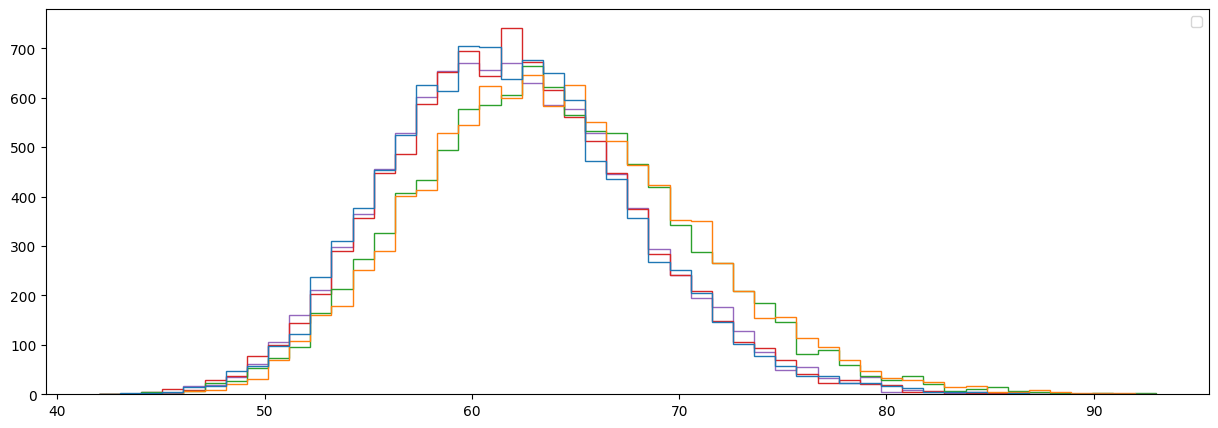

In [75]:
fig, ax = plt.subplots(figsize=[15, 5])

# for i,gl_stacked_ in enumerate(gl_stacked):
#         ax.bar([x for x, _ in gl_stacked_], [
#                 y for _, y in gl_stacked_], alpha=0.5, label=xlabels[i])
#         # ax.plot(gl[i], alpha=0.5)
ax.hist(gl,histtype="step",bins=50,)
plt.legend()

In [67]:
[{"strats":[s.getName() for s in gs[i].getStrategies()],"min":np.min(gl_),"median":np.median(gl_),"avg":np.average(gl_),"max":np.max(gl_)} for i,gl_ in enumerate(gl)]

[{'strats': ['Score', 'Score'],
  'min': 44,
  'median': 62.0,
  'avg': 61.940511897620475,
  'max': 89},
 {'strats': ['Score', 'MoveFirst'],
  'min': 45,
  'median': 64.0,
  'avg': 64.09288142371526,
  'max': 91},
 {'strats': ['Score', 'Score'],
  'min': 42,
  'median': 63.0,
  'avg': 63.80523895220956,
  'max': 93},
 {'strats': ['Score', 'MoveFirst'],
  'min': 45,
  'median': 62.0,
  'avg': 62.0251949610078,
  'max': 89},
 {'strats': ['MoveFirst', 'Score'],
  'min': 44,
  'median': 62.0,
  'avg': 62.02989402119576,
  'max': 85}]

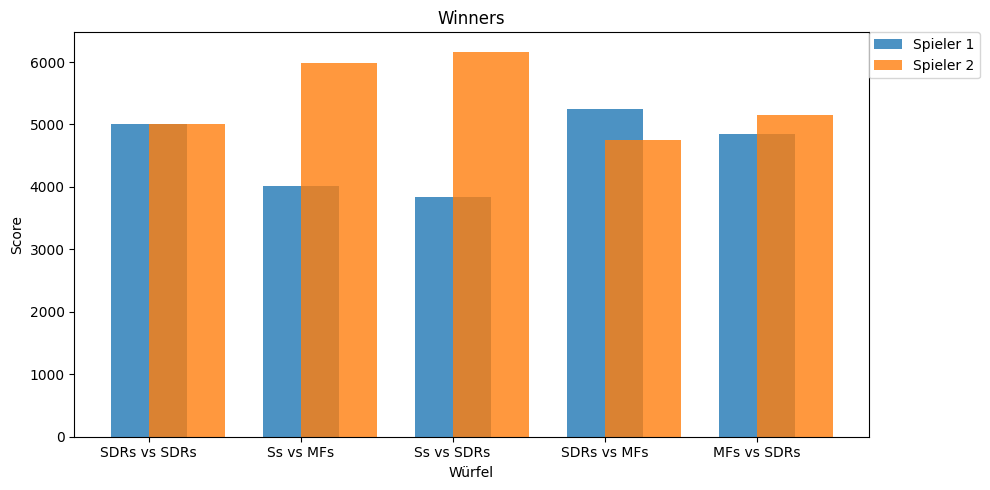

In [68]:
# xlabels = ['No Influence', 'fight', 'fight incl. double']
# xlabels = ["MultiD2Dice(4)",
# "MultiD2Dice(3)",
# "MultiD2DiceNo0(3)",
# "D4()"]
# xlabels=["MF vs MF","S vs MF","S vs S"]
player0 = [[[p.getID() for p in g["winner"]]for g in s].count([0])for s in h]
player1 = [[[p.getID() for p in g["winner"]]for g in s].count([1])for s in h]

fig, ax = plt.subplots(figsize=[10,5])
# hat_graph(ax, xlabels, [player0, player1], ['Player 0', 'Player 1'])

ax.bar(xlabels,player0,label="Spieler 1", alpha=.8,width=.5)
ax.bar(xlabels,player1,label="Spieler 2", alpha=.8,width=.5,align="edge")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Würfel')
ax.set_ylabel('Score')
ax.set_title('Winners')
ax.legend( bbox_to_anchor=(1, 1),
          loc='upper left', borderaxespad=0.)

fig.tight_layout()
plt.show()
